In [1]:
# Building networks with vgg19.mat

In [2]:
import tensorflow as tf
import numpy as np
import scipy.io
from matplotlib import pyplot as plt 
from tqdm import trange

In [3]:
data_path = "../imagenet-vgg-verydeep-19.mat"

In [4]:
data = scipy.io.loadmat(data_path)

In [5]:
VGG19_LAYERS = (
    'conv1_1', 'relu1_1', 'conv1_2', 'relu1_2', 'pool1',

    'conv2_1', 'relu2_1', 'conv2_2', 'relu2_2', 'pool2',

    'conv3_1', 'relu3_1', 'conv3_2', 'relu3_2', 'conv3_3',
    'relu3_3', 'conv3_4', 'relu3_4', 'pool3',

    'conv4_1', 'relu4_1', 'conv4_2', 'relu4_2', 'conv4_3',
    'relu4_3', 'conv4_4', 'relu4_4', 'pool4',

    'conv5_1', 'relu5_1', 'conv5_2', 'relu5_2', 'conv5_3',
    'relu5_3', 'conv5_4', 'relu5_4'
)

In [6]:
weights = data['layers'][0]

In [7]:
def _conv_layer(input, weights, bias):
    # [batch, height, width, channels]
    conv = tf.nn.conv2d(input, tf.constant(weights), strides=(1, 1, 1, 1),
            padding='SAME')
    return tf.nn.bias_add(conv, bias)
def _pool_layer(input, pooling):
    if pooling == 'avg':
        return tf.nn.avg_pool(input, ksize=(1, 2, 2, 1), strides=(1, 2, 2, 1),
                padding='SAME')
    else:
        # [batch, height, width, channels]
        return tf.nn.max_pool(input, ksize=(1, 2, 2, 1), strides=(1, 2, 2, 1),
                padding='SAME')

In [8]:
# two method, to check whether the second method will create less parameters?

In [9]:
def fun_net(current):
    pooling = 'avg'
    net = {}

    for i, name in enumerate(VGG19_LAYERS):
        kind = name[:4]
        if kind == 'conv':
            kernels, bias = weights[i][0][0][0][0]
            # matconvnet: weights are [width, height, in_channels, out_channels]
            # tensorflow: weights are [height, width, in_channels, out_channels]
            kernels = np.transpose(kernels, (1, 0, 2, 3))
            bias = bias.reshape(-1)
            current = _conv_layer(current, kernels, bias)
        elif kind == 'relu':
            current = tf.nn.relu(current)
        elif kind == 'pool':
            current = _pool_layer(current, pooling)

        else:
            assert(0)

        net[name] = current
        
    return net

In [10]:
# define loss

In [11]:
x_var = tf.Variable(tf.random_normal( [1,224,224,3] ))

In [12]:
x_var_feature = fun_net(x_var)

In [49]:
img_style = scipy.misc.imread( "style5.jpg" , mode='RGB').astype(np.float32)
img_style = scipy.misc.imresize(img_style, [224, 224])

/home/inksci/miniconda3/envs/tf-gpu-v4-pil/lib/python2.7/site-packages/ipykernel_launcher.py:1: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  """Entry point for launching an IPython kernel.
/home/inksci/miniconda3/envs/tf-gpu-v4-pil/lib/python2.7/site-packages/ipykernel_launcher.py:2: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
  


In [50]:
scipy.misc.imsave('style-use.png', img_style)


/home/inksci/miniconda3/envs/tf-gpu-v4-pil/lib/python2.7/site-packages/ipykernel_launcher.py:1: DeprecationWarning: `imsave` is deprecated!
`imsave` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imwrite`` instead.
  """Entry point for launching an IPython kernel.


In [14]:
img_content = scipy.misc.imread( "content2.jpg" , mode='RGB').astype(np.float32)
img_content = scipy.misc.imresize(img_content, [224, 224])

/home/inksci/miniconda3/envs/tf-gpu-v4-pil/lib/python2.7/site-packages/ipykernel_launcher.py:1: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  """Entry point for launching an IPython kernel.
/home/inksci/miniconda3/envs/tf-gpu-v4-pil/lib/python2.7/site-packages/ipykernel_launcher.py:2: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
  


In [15]:
img_input_style = tf.placeholder('float32', shape=[1, 224, 224, 3])
img_feature_style = fun_net( img_input_style )

In [16]:
img_input_content = tf.placeholder('float32', shape=[1, 224, 224, 3])
img_feature_content = fun_net( img_input_content )

In [17]:
def style_loss(feature_bank_x, feature_bank_style):
    #style loss
    E = 0
    for layer in feature_bank_style.keys():
        if layer == "relu1_1" or layer=="relu2_1" or layer=="relu3_1" or layer=="relu4_1" or layer=="relu5_1":
            w = 0.2
#         else:
#             w = 0

            H = int(feature_bank_x[layer].shape[1])
            W = int(feature_bank_x[layer].shape[2])

            C = int(feature_bank_x[layer].shape[-1])
            F = tf.reshape(tf.transpose(feature_bank_x[layer], [0, 3, 1, 2]), shape=[C, -1])
            #Gram matrix of x
            G_x = tf.matmul(F, tf.transpose(F))

            C = int(feature_bank_style[layer].shape[-1])
            F = tf.reshape(tf.transpose(feature_bank_style[layer], [0, 3, 1, 2]), shape=[C, -1])
            #Gram matrix of style
            G_s = tf.matmul(F, tf.transpose(F))
            E += w * tf.reduce_sum(tf.square(G_x - G_s)) / (4 * C**2 * H**2 * W**2)
    return E

In [18]:
loss_style = style_loss( x_var_feature, img_feature_style )

In [19]:
loss_content = tf.norm(img_feature_content['relu5_1']-x_var_feature['relu5_1'], 'euclidean')/tf.norm(img_feature_content['relu5_1'], 'euclidean')

In [20]:
loss = loss_style*1e-4 + loss_content*1e4

In [21]:
global_step = tf.Variable(0, trainable=False, name='global_step')

In [22]:
train_step = tf.train.AdamOptimizer(learning_rate=0.1, beta1=0.5).minimize(loss, global_step = global_step)

In [23]:
# out = sess.run( fun_net(x_var),feed_dict={img_input:[img]} )

In [24]:
# forward

In [25]:
gpu_options = tf.GPUOptions(allow_growth=True)  

In [26]:
sess = tf.Session(config=tf.ConfigProto(gpu_options=gpu_options))
sess.run(tf.global_variables_initializer())

In [27]:
# sess.run(tf.assign(x_var, np.array([img_content]) ))

In [28]:
sess.run( loss_style, feed_dict={img_input_style:[img_style]} )

2.0726496e+09

In [29]:
sess.run( loss_content, feed_dict={img_input_content:[img_content]} )

0.99656111

In [30]:
# Set the value of content image

In [31]:
loss_list = []

In [32]:
for _ in trange(15000):
    _, loss_out = sess.run([train_step,loss],feed_dict={img_input_style:[img_style], img_input_content:[img_content] })
    loss_list.append(loss_out)

100%|██████████| 15000/15000 [22:16<00:00, 11.22it/s]


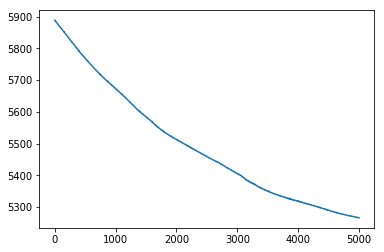

In [37]:
plt.plot(loss_list[10000:]) 
plt.show()

In [34]:
out_x = sess.run(x_var)

In [35]:
out_x.shape

(1, 224, 224, 3)

In [36]:
scipy.misc.imsave('style-content.png', out_x[0])


/home/inksci/miniconda3/envs/tf-gpu-v4-pil/lib/python2.7/site-packages/ipykernel_launcher.py:1: DeprecationWarning: `imsave` is deprecated!
`imsave` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imwrite`` instead.
  """Entry point for launching an IPython kernel.
